In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import emp_graphics as eg
import networkx as nx
import graphics as gx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par

# parameters
agg_periods = [1, 50, 100, 250]
path_results = "./results/empirical_results/"

# 1 data preprocessing

In [ ]:
# load fake data (mmsr)
df_mmsr = ef.get_df_mmsr(nb_tran=int(1e4))
dic_obs_matrix_reverse_repo = ep.build_from_mmsr(df_mmsr=df_mmsr)

In [2]:
# load fake data (exposure)
df_exposures = ef.get_df_exposures(lines=int(1e5))
dic_obs_matrix_reverse_repo = ep.build_from_exposures(df_exposures=df_exposures)

100%|██████████| 100000/100000 [00:23<00:00, 4273.32it/s]


In [ ]:
# load real data 
df_exposures = pd.read_stata("to be filled")
dic_obs_matrix_reverse_repo = ep.build_from_exposures(df_exposures=df_exposures)

In [2]:
# load dic directly (faster)
dic_obs_matrix_reverse_repo = ep.get_dic_obs_matrix_reverse_repo()

# 2 metrics measurement

In [3]:
# get aggregated adjency matrices
dic_binary_adjs = em.get_binary_adjs(dic_obs_matrix_reverse_repo, agg_periods)

/opt/tmp/tmp/ipykernel_424743/4068642703.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = pd.Series()


<AxesSubplot: >

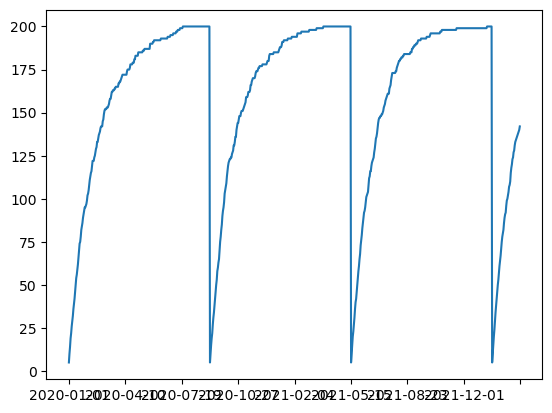

In [4]:
test = pd.Series()
days = list(list(dic_binary_adjs.values())[0].keys())
for i in days[:800]:
    test.loc[i] = (dic_binary_adjs[250][i].sum())
test.plot()

## 2.1 jaccard

In [5]:
# get jaccard
df_jaccard = em.get_jaccard(dic_binary_adjs)
eg.plot_jaccard_aggregated(df_jaccard, path_results)

## 2.2 density

In [6]:
# get density
df_density = em.get_density(dic_binary_adjs)
eg.plot_network_density(df_density, path_results)

## 2.3 distribution of in and out degree

In [7]:
# for the exposures
dic_obs_matrix_reverse_repo = ep.get_dic_obs_matrix_reverse_repo()
dic_binary_adjs = em.get_binary_adjs(dic_obs_matrix_reverse_repo, agg_periods)
dic_in_degree, dic_out_degree = em.get_degree_distribution(dic_binary_adjs)
eg.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    f"{path_results}degree_distribution/",
    name="degree_distribution_reverse_repos",
    save_every=1000)


## 2.4 core periphery

/mnt/live/user/vlecoz/Secured_interbank_network/emp_graphics.py:141: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sr_pvalue = pd.Series()
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/cpnet/qstest.py:94: UserWarning: 'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.
  warnings.warn("'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.")
100%|██████████| 100/100 [00:00<00:00, 801.93it/s]
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/cpnet/qstest.py:94: UserWarning: 'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.
  warnings.warn("'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.")
100%|██████████| 

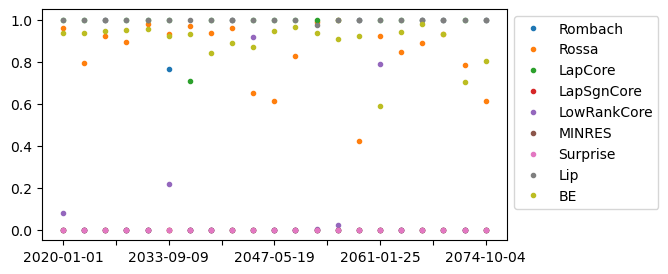

In [2]:
# load dic directly (faster)
dic_obs_matrix_reverse_repo = ep.get_dic_obs_matrix_reverse_repo()
eg.mlt_get_n_plot_cp_test(dic_obs_matrix_reverse_repo, algos=par.cp_algos,save_every=1000, path_results=path_results)

## 2.5 asset per degree (to be completed)

In [ ]:
ef.get_df_finrep()

# 3 tools

## 3.1 examples of density / histogram in log - log

### pareto law

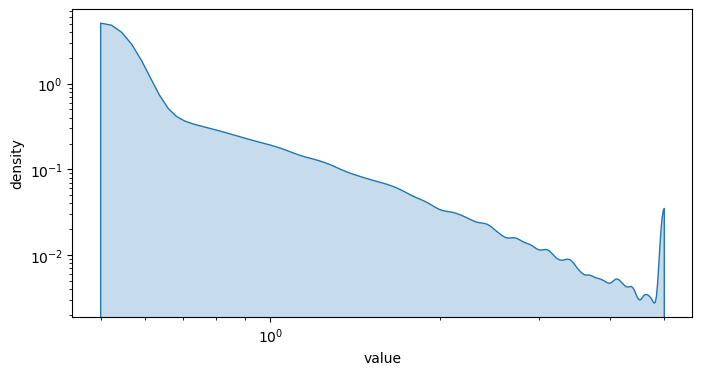

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

### student law

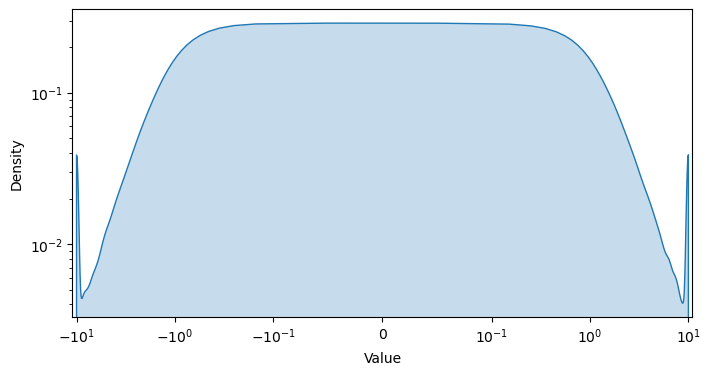

In [166]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## 3.2 multiple histogram on the same plot

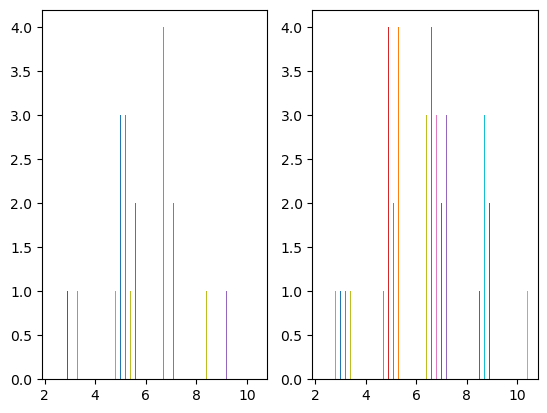

In [7]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1

